# Set Up
## Import

In [10]:
import cupy as cp
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time

## Settings

In [11]:
#CAUTION: if R is chosen too small and N too high, then when the program will try to calculate the inverse of dGr
# in the calculation of the saturated density profile, the following error will show: 'Matrix singular to numerical precision.'
# for example, for R=0.75, N=1000 is too high.  
R=0.75#cm
H=0.2 #cm
N=500
M=200
position_of_electrons=100

hr=R/N
hz=H/M

e=4.80324e-10

N_Vib=cp.round(0.4/hr)
N_Vmb=cp.round(0.57/hr)
N_Vob = cp.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)

eps=1e-10
header = "R"+str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps))

# Define Functions

In [12]:
iRange = cp.arange(2, N+1)

@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = cp.full((M+1,N+1),-1/300)
fitil = cp.full((M+1,N+1),-1/300)
aStart = cp.zeros((M-1, N+1))
a = cp.zeros((M-1, N+1))

def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    
    
    cp.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = 1e-8
    print(count)
    cp.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        cp.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(cp.abs(fitil[1:M, 0:N+1] - a))

    return fitil
    
    
    


In [13]:
preCalcDisStat = np.arange(1, N+1)

@jit(nopython = True, fastmath=True, parallel=True)
def distribSTATIC(R,H,N,M,G,Ertil,dGr,radius_of_electron_pool):

    dens = np.zeros(N+1)
    dens[:int(radius_of_electron_pool)+1] = np.dot(Ertil[:int(radius_of_electron_pool)+1], np.linalg.inv(dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]))

    A = np.zeros(N+1)

    A[0] = np.pi * np.power((hr/2), 2)
    A[N] = np.pi *(N - 5/4) * np.power(hr, 2)
    A[0:N] = 2 * np.pi * (preCalcDisStat - 1) * np.power(hr, 2)
    
    temp = A[0:len(dens)] * dens[0:len(dens)]
    
    N_total = np.sum(temp)
    
    return dens, N_total, A, temp

# Calculations

## Load Green Function

Green_R0pt75_H0pt2_N500_M200_posiE100_epsE-10.0.npy
(201, 501, 501)


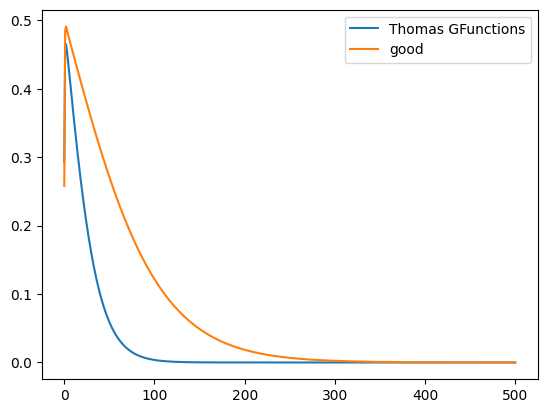

In [14]:
# # ------------ Load Green Function  ------------ #
GreenFuncName = 'Green_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '.npy'
print(GreenFuncName)
G_old = np.load("GreenFunctions/" +GreenFuncName)
G=np.load('GreenFunctions/good_versions//'+GreenFuncName)
print(G.shape)
plt.plot(G_old[position_of_electrons,0,:], label='Thomas GFunctions')
plt.plot(G[position_of_electrons,0,:], label='good')
plt.legend()
#G = np.transpose(Gin, axes = (0, 2, 1))

In [15]:
dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))
dGzBOTTOM = np.zeros((N, N))

# # ----------- Green function difference along the charge pool ----------- #
for n in range(0, N):
    for i in range(0, N):
        dGr[n,i] = -4*np.pi*e*(G[position_of_electrons,i+1,n]-G[position_of_electrons,i,n])
    
# # ----------- Green function difference across the cell's top ----------- #
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz) #for testing
        

# # ----------- Green function difference across the cell's bottom ----------- #
        dGzBOTTOM[n,i] = -4 * np.pi * e * (G[1,i,n]-G[0,i,n])*(hr/hz)

## Choose the voltage sweep

In [16]:
Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Vit=0/300 #statvolt
Vmt=0/300 #statvolt
Vot=0/300 #statvolt

Vr=0/300 #statvolt

# Vmb =15/300
Vib = 17/300
Vmb=17/300

# Vob = cp.arange(-96, -5.5, 0.5)/300
Vob_start=0
Vob_stop=-160
Vob_step=-0.3

Vob = cp.arange(Vob_start, Vob_stop, Vob_step)/300


## Calculate $\tilde \Phi$ (if it is already calculated, do not run this code)

In [17]:
def phitilGen():

    phitilInitial = fitilSOLUT(R,H,N,M,Vib,Vmb,Vob[0],N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)

    phitilList = cp.array(np.zeros((len(Vob), np.shape(phitilInitial)[0], np.shape(phitilInitial)[1])))

    phitilList[0] = phitilInitial
    

    for i in range(1, len(Vob)):
        print(len(Vob) - i)
        phitilList[i] = fitilSOLUT(R,H,N,M,Vib,Vmb,Vob[i],N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt,N_Vot, N_Vob, Vr)
        

    return phitilList

phitilList = phitilGen()


0
1.513985603586454e-06
6.241325619486815e-07
2.6550944776798646e-07
1.1276838183388316e-07
4.772751497836292e-08
2.011516097785715e-08
533
0
1.5139856032256316e-06
6.241323962617729e-07
2.655077718863308e-07
1.1276353536343597e-07
4.772119420112797e-08
2.0109655957806227e-08
532
0
1.5139856028544008e-06
6.24132230557517e-07
2.655060959873279e-07
1.1275868889645824e-07
4.7714873434301364e-08
2.010415096551088e-08
531
0
1.5139856024901088e-06
6.241320648775472e-07
2.655044201056722e-07
1.1275384242601105e-07
4.7708552660535863e-08
2.00986459558683e-08
530
0
1.5139856021223475e-06
6.241318991802303e-07
2.655027442136082e-07
1.1274899595556387e-07
4.770223189023981e-08
2.009314093234793e-08
529
0
1.5139856017441777e-06
6.241317334933216e-07
2.6550106833195253e-07
1.1274414948164724e-07
4.7695911123413204e-08
2.0087635929644243e-08
528
0
1.5139856013833553e-06
6.241315678029435e-07
2.654993924329496e-07
1.1273930300773061e-07
4.7689590349647704e-08
2.0082130916532215e-08
527
0
1.5139856010

### Save PhiTilList

In [18]:

PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-8)) + '_Vob_step='+ str(Vob_step).replace('.','pt')+ '_Vob_start=' +str(Vob_start).replace('.','pt') +'_Vob_stop='+ str(Vob_stop).replace('.','pt') + '.npy'
fileName = "phiFiles/"+str(int(Vmb*300))+ "V/" + str(PhiTilName)

phitilNump = cp.asnumpy(phitilList)
np.save(fileName, phitilNump)

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

In [145]:
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-8)) + '_Vob_step='+ str(Vob_step).replace('.','pt')+ '_Vob_start=' +str(Vob_start).replace('.','pt') +'_Vob_stop='+ str(Vob_stop).replace('.','pt') + '.npy'
fileName = "phiFiles/"+str(int(Vmb*300))+ "V/" + str(PhiTilName)
print(fileName)

phiFiles/20V/Phi_R0pt75_H0pt21_N500_M200_posiE100_epsE-8.0_Vob_step=0pt3_Vob_start=-160_Vob_stop=20.npy


## Load PhiTilList if already calculated

In [19]:
# in the filename, change the Vob step to the one you used in the phitilGen function
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-8)) + '_Vob_step='+ str(Vob_step).replace('.','pt')+ '_Vob_start=' +str(Vob_start).replace('.','pt') +'_Vob_stop='+ str(Vob_stop).replace('.','pt') + '.npy'
fileName = "phiFiles/"+str(int(Vmb*300))+ "V/" + str(PhiTilName)
print(PhiTilName)
phitilNump=np.load(fileName)
print(np.shape(phitilNump))

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)


Phi_R0pt75_H0pt2_N500_M200_posiE100_epsE-8.0_Vob_step=-0pt3_Vob_start=0_Vob_stop=-160.npy
(534, 201, 501)


## Saturated density profile

In [21]:
print(phitilNump.shape)
print(len(Vob))


(534, 201, 501)
534


534
Iterations Left: 535
Iterations Left: 534
Iterations Left: 533
Iterations Left: 532
Iterations Left: 531
Iterations Left: 530
Iterations Left: 529
Iterations Left: 528
Iterations Left: 527
Iterations Left: 526
Iterations Left: 525
Iterations Left: 524
Iterations Left: 523
Iterations Left: 522
Iterations Left: 521
Iterations Left: 520
Iterations Left: 519
Iterations Left: 518
Iterations Left: 517
Iterations Left: 516
Iterations Left: 515
Iterations Left: 514
Iterations Left: 513
Iterations Left: 512
Iterations Left: 511
Iterations Left: 510
Iterations Left: 509
Iterations Left: 508
Iterations Left: 507
Iterations Left: 506
Iterations Left: 505
Iterations Left: 504
Iterations Left: 503
Iterations Left: 502
Iterations Left: 501
Iterations Left: 500
Iterations Left: 499
Iterations Left: 498
Iterations Left: 497
Iterations Left: 496
Iterations Left: 495
Iterations Left: 494
Iterations Left: 493
Iterations Left: 492
Iterations Left: 491
Iterations Left: 490
Iterations Left: 489
Iteration

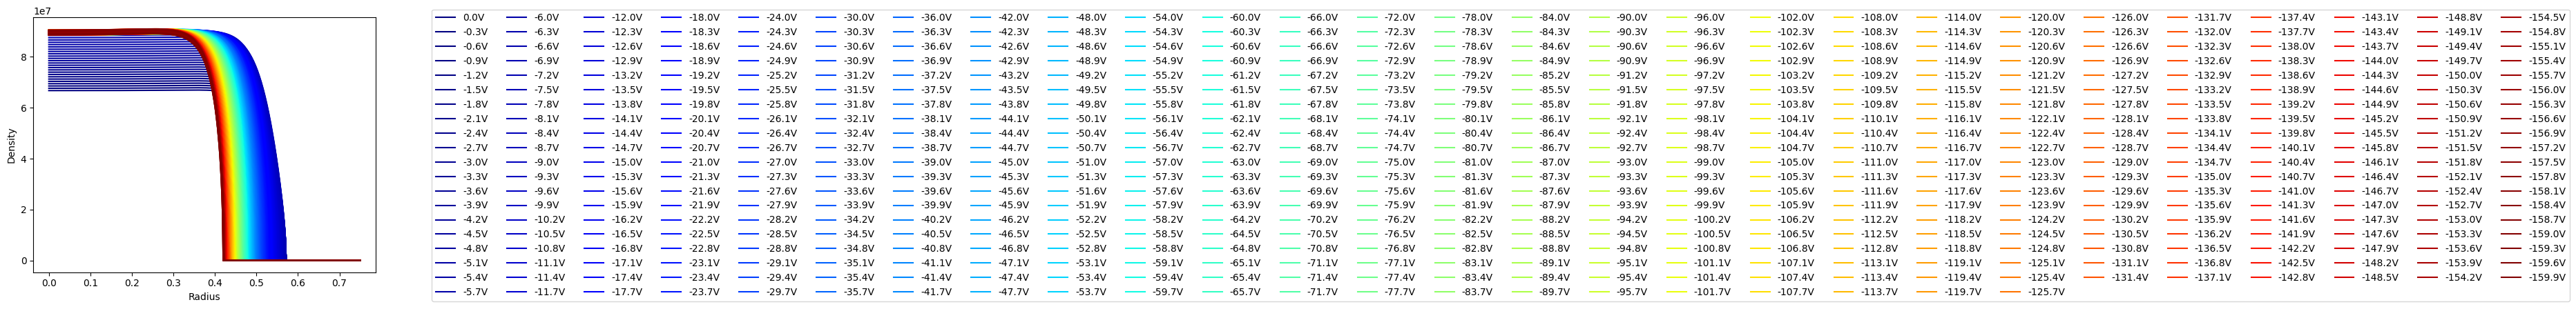

In [22]:
#for each potential, calculates the density profile (depeding on the radus of the electron pool)
Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)
print(len(phitilNump))

N_total_list = np.zeros(len(phitilNump))
N_per_ring_list = np.zeros((len(phitilNump), N+1))
denList = np.zeros((len(phitilNump), N+1))
density_max_list = np.zeros(len(phitilNump))
R_star_list = np.zeros(len(phitilNump))
for l in range(0, len(phitilNump)):

    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]

        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    


    radius_of_electron_pool = np.round(0.57/hr)
    

    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])

    
    for k in range(0, len(radius_of_electron_pool_list)):

        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        

        # ------------- induced charge at the top inner electrode ------------------- #
        Ez = EztilTOP[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind=Qsum/e

        # ------------- induced charge at the bottom inner electrode ------------------- #
        Ez = EztilBOTTOM[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind = Qsum/e

        # ------------  potential at/below/above the electrons ------------ #


        copyAr2D(G_at_electrons, G[position_of_electrons].T)
        copyAr2D(G_below_electrons, G[position_of_electrons-1].T)
        copyAr2D(G_above_electrons, G[position_of_electrons+1].T)
        
        phi_at_electrons = phitil[position_of_electrons] - 4 * np.pi * e * hr * np.dot(density, G_at_electrons)
        phi_below_electrons = phitil[position_of_electrons-1] - 4 * np.pi * e * hr * np.dot(density, G_below_electrons)
        phi_above_electrons = phitil[position_of_electrons+1] - 4 * np.pi * e * hr * np.dot(density, G_above_electrons)

        # ---------- electric r-field across the liquid surface  ---------- #
        Er = np.zeros(N)

        Er[0:N] = (phi_at_electrons[0:N] - phi_at_electrons[1:N+1])/hr
        
        # ------------ electric field acting on electrons  ---------------- #
        Ezbelow[0:N+1] = (phi_below_electrons[0:N+1] - phi_at_electrons[0:N+1])/hz
        Ezabove[0:N+1] = (phi_at_electrons[0:N+1] - phi_above_electrons[0:N+1])/hz
        
        # adds the electric field acting on the electrons at the center to a list 
        Ezuplist[k] = Ezabove[0]
    
    
    minimum = np.amin(np.abs(Ezuplist))
    # chooses the index of the smallest absolute value of the electric field acting on the electrons at the center
    idx = np.argmin(np.abs(Ezuplist))

    # chooses the radius of the electron pool accordingly
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    #calculates the final density profile with the chosen radius of the electron pool
    # this is done for every potential in the Vob sweep
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
    
    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    N_per_ring_list[l] = N_per_ring

colors = plt.cm.jet(np.linspace(0,1,len(denList)))

for d in range(0, len(denList)):
    print(Vob[d])
    plt.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(np.round(Vob[d] * 300,1))+'V')


plt.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
plt.ylabel("Density")
plt.xlabel("Radius")
plt.show()



### Run if you want to save the saturated densities

In [26]:
for idx in range(len(denList)):
    Vob_str = f"{Vob[idx] * 300:.1f}".replace(".", "p")
    filename = f"NewDensityFiles/Vob_sweep_17V_starting0/saturated_density_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)

#filename
data_to_save

array([[0.00000000e+00, 1.50000000e-03, 3.00000000e-03, ...,
        7.47000000e-01, 7.48500000e-01, 7.50000000e-01],
       [8.88395580e+07, 8.88424925e+07, 8.88418968e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Fixed N Density List

<>:87: SyntaxWarning: invalid escape sequence '\e'
<>:87: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_8736\2899267613.py:87: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')


Iterations Left: 535
380.0
0.0
Iterations Left: 534
380.0
-0.0008972700247987385
Iterations Left: 533
380.0
-0.002185917916888204
Iterations Left: 532
380.0
-0.00386967093059317
Iterations Left: 531
380.0
-0.005950667054925405
Iterations Left: 530
380.0
0.006759721520795756
Iterations Left: 529
380.0
0.004131959191987791
Iterations Left: 528
380.0
0.0011017820866081967
Iterations Left: 527
380.0
-0.0023290180990574024
Iterations Left: 526
380.0
-0.006157209710536106
Iterations Left: 525
380.0
0.005937310423186252
Iterations Left: 524
380.0
0.0015524894661000227
Iterations Left: 523
380.0
-0.0032235349314582323
Iterations Left: 522
380.0
-0.008383930637772435
Iterations Left: 521
380.0
0.003212883717068922
Iterations Left: 520
380.0
-0.0024959716329661574
Iterations Left: 519
380.0
-0.008575512661653207
Iterations Left: 518
380.0
0.002676613373893493
Iterations Left: 517
380.0
-0.003939184327546494
Iterations Left: 516
380.0
0.0071375247862209765
Iterations Left: 515
380.0
-7.8718316431

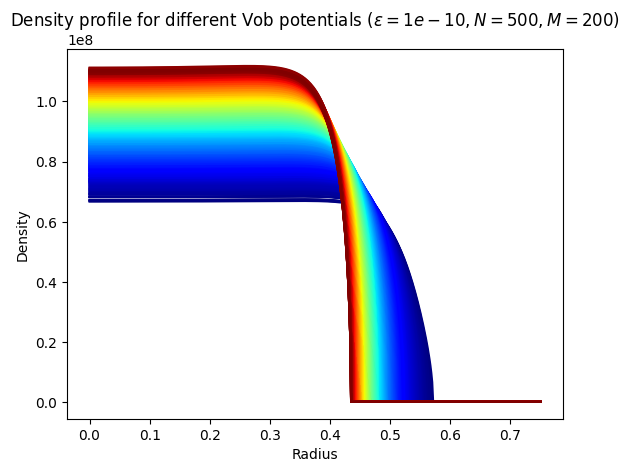

In [27]:
Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)

N_Fixed_list = np.copy(N_total_list)

# fix the number of electrons to be equal to the number of electrons at Vob=-96V 
# indeed the sweep of Vob is done from -96V to -5.5V, so the number of electrons at Vob=-96V is the one that is fixed



N_Fixed = N_total_list[0]

for l in range(0, len(phitilNump)):

    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]



        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    radius_of_electron_pool = np.round(0.57/hr)
    print(radius_of_electron_pool)
    
    #radius_of_electron_pool_list = np.arange(radius_of_electron_pool - 350,radius_of_electron_pool+1)
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])


    N_total_vect = np.zeros(len(radius_of_electron_pool_list))
    for k in range(0, len(radius_of_electron_pool_list)):
        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        N_total_vect[k] = N_total
    minimum = np.amin(np.abs(N_total_vect - N_Fixed))
    idx = np.argmin(np.abs(N_total_vect - N_Fixed))

    
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)

    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    print((N_total-N_Fixed)/N_Fixed)
    
colors = plt.cm.jet(np.linspace(0,1,len(denList)))

for d in range(0, len(denList)):
    plt.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(Vob[d] * 300)+'V')

plt.ylabel("Density")
plt.xlabel("Radius")
# plt.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
plt.title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')
plt.show()


plt.show()

In [28]:
#the file DensityFiles/EPS{int(np.log10(eps))} needs to be created before running the code
for idx in range(len(denList)):
    Vob_str = f"{Vob[idx] * 300:.1f}".replace(".", "p")
    filename = f"NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    # filename = f"DensityFiles/EPS{int(np.log10(eps))}/FixedN_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    print(filename)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)



NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob0p0_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-0p3_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-0p6_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-0p9_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-1p2_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-1p5_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-1p8_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-2p1_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-2p4_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-2p7_N500_M200_posiE100.npy
NewDensityFiles/Vob_sweep_17V_starting0/FixedN_Vib17_Vmb17_Vob-3p0_N500_M200_posiE100.npy
NewDensityF